1. Deciding the items

In [66]:
# Create class.txt
f = open("class.txt", "r")
# Read the class
classes = f.readlines()
f.close()

In [67]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]
print(classes)

['banana', 'star', 'circle', 'house']


In [68]:
# Create a directory to store the dataset
!mkdir data

mkdir: data: File exists


In [69]:
import urllib.request
def download():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [70]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy


https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/circle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/house.npy


2. Load data

In [71]:
import numpy as np
import glob 
import os 
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

In [72]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    # Get the list of npy files in the path directory
    all_files = glob.glob(os.path.join(root, '*.npy'))

    # Initiate variables for input features(x) and labels(y)
    x = np.empty([0, 784]) 
    y = np.empty([0]) 

    # Create an array for 4 of our classes
    class_names = []

    # Load each data file
    for idx, file in enumerate(all_files):

        data = np.load(file)

        # Limit the number of maximum items for class to the defined parameter
        data = data[0: max_items_per_class, :]

        # Create labels for the loaded data
        labels = np.full(data.shape[0], idx)

        # Concatenate existing image and labels into x and y
        x = np.concatenate((x, data), axis=0) 
        y = np.append(y, labels) 

        # Extract class name and extension from the path name then add it to the list
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    # Randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    # Separate into training and testing based on vfold ratio
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [73]:
# Split the dataset into training set and testing set
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

ValueError: can only convert an array of size 1 to a Python scalar

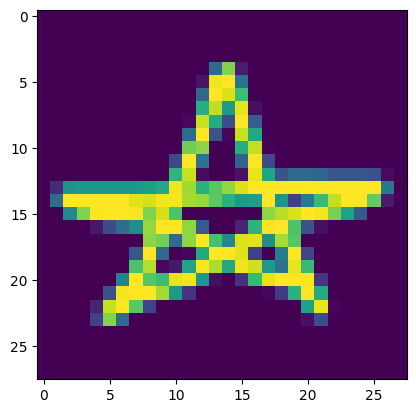

In [88]:
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

3. Preprocess the data

In [75]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import tensorflow as tf

In [76]:
# Reshape and normalise
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255
x_test /= 255

# Convert class labels into one-hot encoded vector
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [77]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

In [78]:
# Increase model capacity
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

# Regularization and increased complexity
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Epoch 1/20
50/50 [==============================] - 4s 55ms/step - loss: 0.9358 - accuracy: 0.6000 - val_loss: 0.3187 - val_accuracy: 0.9078
Epoch 2/20
50/50 [==============================] - 3s 51ms/step - loss: 0.4570 - accuracy: 0.8462 - val_loss: 0.2669 - val_accuracy: 0.9175
Epoch 3/20
50/50 [==============================] - 3s 52ms/step - loss: 0.3169 - accuracy: 0.8988 - val_loss: 0.1536 - val_accuracy: 0.9575
Epoch 4/20
50/50 [==============================] - 3s 55ms/step - loss: 0.2567 - accuracy: 0.9172 - val_loss: 0.1614 - val_accuracy: 0.9534
Epoch 5/20
50/50 [==============================] - 3s 52ms/step - loss: 0.2128 - accuracy: 0.9372 - val_loss: 0.1427 - val_accuracy: 0.9631
Epoch 6/20
50/50 [==============================] - 2s 50ms/step - loss: 0.2066 - accuracy: 0.9356 - val_loss: 0.1304 - val_accuracy: 0.9634
Epoch 7/20
50/50 [==============================] - 3s 52ms/step - loss: 0.1739 - accuracy: 0.9441 - val_loss: 0.1076 - val_accuracy: 0.9669
Epoch 8/20
50

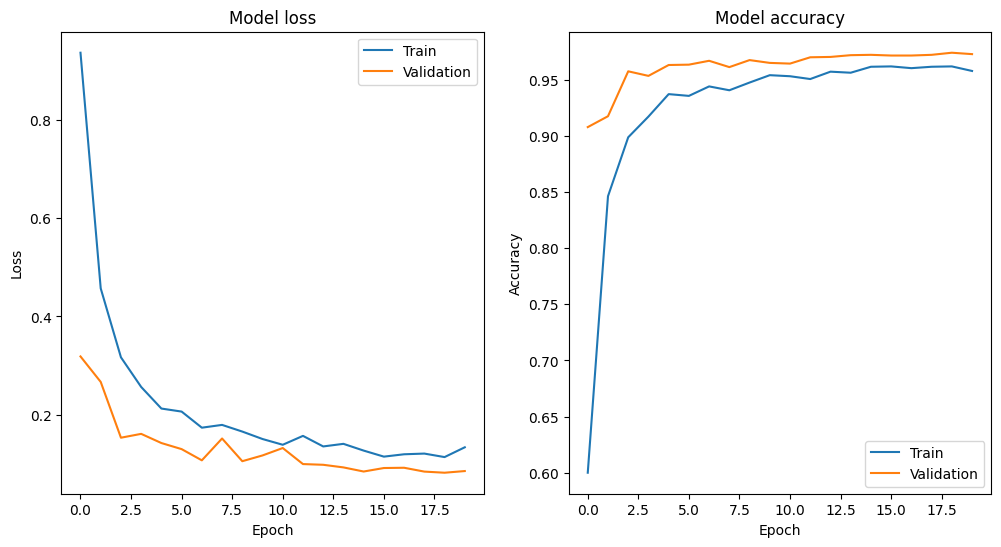

In [79]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // 256,
    epochs=20,
    callbacks=[early_stopping]
)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

In [80]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 97.28%


1/1 [==============================] - 0s 24ms/step
['banana', 'circle', 'star', 'house']


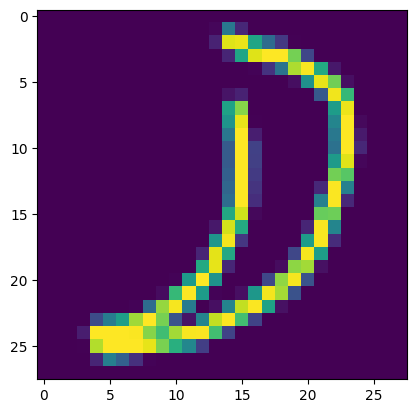

In [84]:
# Inference

import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [82]:

#storing classes
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [83]:
#saving the model and download it into laptop
model.save('keras.h5')